In [1]:
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from torchvision.io import read_image
import torchvision.transforms as T
import torch.nn as nn
import os
import PIL

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = T.Compose([
    T.Resize((64, 64)), # Resize images to (64, 64)
    T.ToTensor()  
])

In [4]:
dataset = []
for image in os.listdir('./dogs-cats-mini'):
    dataset.append([transform(PIL.Image.open(f'./dogs-cats-mini/{image}')), 1 if 'cat' in image else 0])


In [5]:
train_set, val_test_set = train_test_split(dataset, test_size=0.3)
val_set, test_set = train_test_split(val_test_set, test_size=0.5)

In [6]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

In [7]:
class ConvNeuralNet(nn.Module):
    # Determine what layers and their order in CNN object
    def __init__(self):
        super(ConvNeuralNet, self).__init__()

        self.convs = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4),
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4),
        )

        self.linear = nn.Sequential(
            nn.Linear(2304, 800),
            nn.ReLU(),
            nn.BatchNorm1d(800),
            nn.Dropout(0.4),
            nn.Linear(800, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 1),
        )

    # Progresses data across layers
    def forward(self, x):
        out = self.convs(x)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [8]:
model = ConvNeuralNet()

# Set Loss function with criterion
criterion = nn.BCEWithLogitsLoss()

# Set optimizer with optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)  

In [9]:
val_loss, train_loss = [], []
epochs = 15
# We use the pre-defined number of epochs to determine how many iterations to train the network on
for epoch in range(epochs):
    t_loss = 0.0
    v_loss = 0.0
    model.train()
    for images, labels in train_loader:

        outputs = model(images)        
        loss = criterion(outputs, labels.unsqueeze(1).float())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # stats
        t_loss += loss.item()
    train_loss.append(t_loss / len(train_loader))

    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            v_loss += loss.item()
    val_loss.append(v_loss / len(val_loader))
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/15], Loss: 0.6598
Epoch [2/15], Loss: 0.5129
Epoch [3/15], Loss: 0.4096
Epoch [4/15], Loss: 0.1133
Epoch [5/15], Loss: 0.5454
Epoch [6/15], Loss: 0.2376
Epoch [7/15], Loss: 0.4196
Epoch [8/15], Loss: 0.3050
Epoch [9/15], Loss: 0.3402
Epoch [10/15], Loss: 0.3786
Epoch [11/15], Loss: 0.3692
Epoch [12/15], Loss: 0.0797
Epoch [13/15], Loss: 0.6412
Epoch [14/15], Loss: 0.2115
Epoch [15/15], Loss: 0.5165


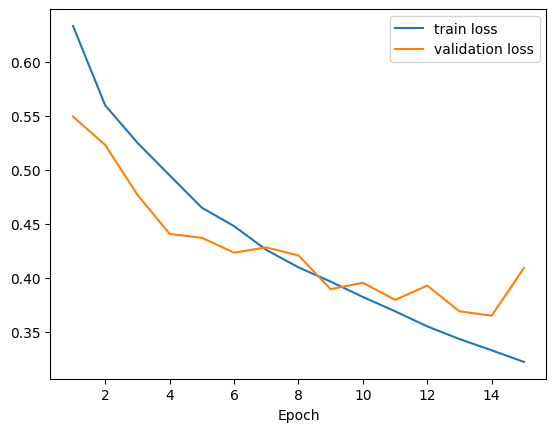

In [10]:
plt.plot(torch.arange(1, epochs+1, 1), train_loss, label='train loss')
plt.plot(torch.arange(1, epochs+1, 1), val_loss, label='validation loss')
plt.xlabel('Epoch')
plt.legend();

In [11]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        predicted = torch.round(torch.sigmoid(outputs))
        total += labels.size(0)
        correct += (predicted == labels.unsqueeze(1)).sum().item()
    print(f'Accuracy of the network on the {total} test images: {100 * correct / total}%')


Accuracy of the network on the 3750 test images: 82.69333333333333%


In [ ]:
all_test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=False)
for images, labels in all_test_loader:
    outputs = model(images)
    predicted = torch.round(torch.sigmoid(outputs))
    cm = confusion_matrix(labels.detach().numpy(), predicted.detach().numpy())
    dips = ConfusionMatrixDisplay(cm, display_labels=['Dog', 'Cat'])
    dips.plot()

In [ ]:
misclassified = []
model.eval()
with torch.no_grad():
    for images, labels in all_test_loader:
        outputs = model(images)
        predicted = torch.round(torch.sigmoid(outputs))
        for i in range(len(labels)):
            if labels[i] != predicted[i]:
                misclassified.append(images[i])
for img in misclassified[:8]:
    i = T.functional.to_pil_image(img)
    plt.imshow(i)
    plt.show()
a = T.functional.to_pil_image(dataset[9][0])
plt.imshow(a)

NameError: name 'model' is not defined